In [9]:
import pandas as pd 
from tensorly.decomposition import tucker

import matplotlib.pyplot as plt 


In [41]:
df = pd.read_csv('resources/data/taz.view_moveandchill.csv',index_col='id')
COLUMN_MAP =  {
    'objectid'      : 'ID',
    'sensor_eui'    : 'sensor_ID',
    'zeitpunkt'     : 'timestamp',
    'temperature'   : 'temperature',
    'humidity'      : 'humidity',
    'latitude'      : 'latitude', 
    'longitude'     : 'longitude',
    'noise'         : 'noise',
    'sit'           : "% occupancy"   # every 15-30 mins the sensor resets and checks occupancy 
    
}
df.rename(columns=COLUMN_MAP,inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S')
df['timestamp'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds().astype(int)
df = df.sort_values(by='timestamp',ascending=True)


In [44]:
df['timestamp']

id
5260   -2060743
5264   -2060528
5268   -2060379
5272   -2060320
5276   -2060242
         ...   
4385    3003537
4708    3005638
4707    3007438
4706    3009238
4705    3011038
Name: timestamp, Length: 29780, dtype: int64

In [52]:
# Check how many timepoints each sensor has
print(df.groupby('sensor_ID').size().sort_values())

sensor_ID
0080E115003BB3B8     200
0080E115003BCA81     252
0080E115003BC9A9     256
0080E1150017F416     372
0080E115003BCA25     904
0080E11500180306    1700
0080E1150017F5F8    1720
0080E115003BC2AD    2188
0080E115003BC996    2208
0080E115003BCA55    2348
0080E1150017A139    2444
0080E115003BE631    2480
0080E115003BC8D7    2504
0080E115003BDA59    2524
0080E115003BCF64    2556
0080E115003BC812    2560
0080E115003BC1DF    2564
dtype: int64


In [53]:
import numpy as np 

df['sensor_ID'].value_counts()

FEATURES = ['humidity','noise', '% occupancy','temperature']

df_trimmed = (
    df.groupby('sensor_ID')
    .apply(lambda x: x.nsmallest(200, 'timestamp'))
    .reset_index(drop=True)
)

sensor_ids = df_trimmed['sensor_ID'].unique()

reshaped = np.array([
    df_trimmed[df_trimmed['sensor_ID'] == sid][FEATURES].values[:250].T  # (n_features, 250)
    for sid in sensor_ids
])  # (Nbat, Nvar, 250)

print(reshaped.shape)  # (n_sensors, 4, 250)

(17, 4, 200)


C:\Users\tudor\AppData\Local\Temp\ipykernel_18192\2908997215.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(200, 'timestamp'))


Core shape: (3, 3, 3)
Factors shapes: [(17, 3), (4, 3), (200, 3)]


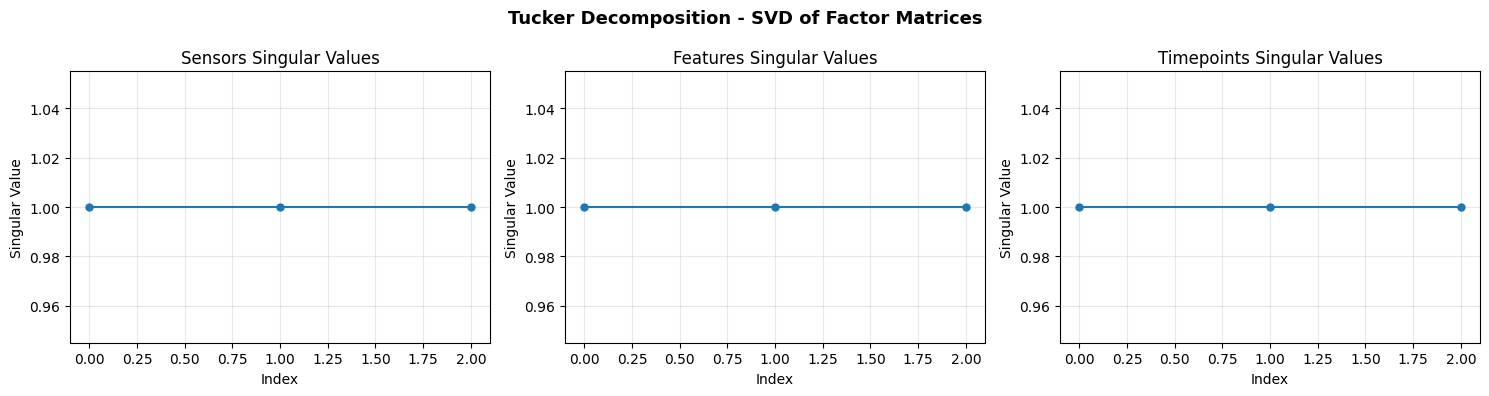

In [58]:
import tensorly as tl
from tensorly.decomposition import tucker
import matplotlib.pyplot as plt
import numpy as np

# Apply Tucker decomposition
ranks = [3,3,3]  # adjust ranks as needed
core, factors = tucker(tl.tensor(reshaped), rank=ranks)

print(f"Core shape: {core.shape}")
print(f"Factors shapes: {[f.shape for f in factors]}")

fig, axes = plt.subplots(1, len(factors), figsize=(15, 4))

for i, (factor, ax) in enumerate(zip(factors, axes)):
    _, singular_values, _ = np.linalg.svd(factor, full_matrices=False)
    
    ax.plot(singular_values, 'o-', linewidth=1.5, markersize=5)
    ax.set_title(f'Mode {i+1} Singular Values\n(shape: {factor.shape})', fontsize=11)
    ax.set_xlabel('Index')
    ax.set_ylabel('Singular Value')
    ax.grid(True, alpha=0.3)

mode_labels = ['Sensors', 'Features', 'Timepoints']
for ax, label in zip(axes, mode_labels):
    ax.set_title(f'{label} Singular Values')

fig.suptitle('Tucker Decomposition - SVD of Factor Matrices', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

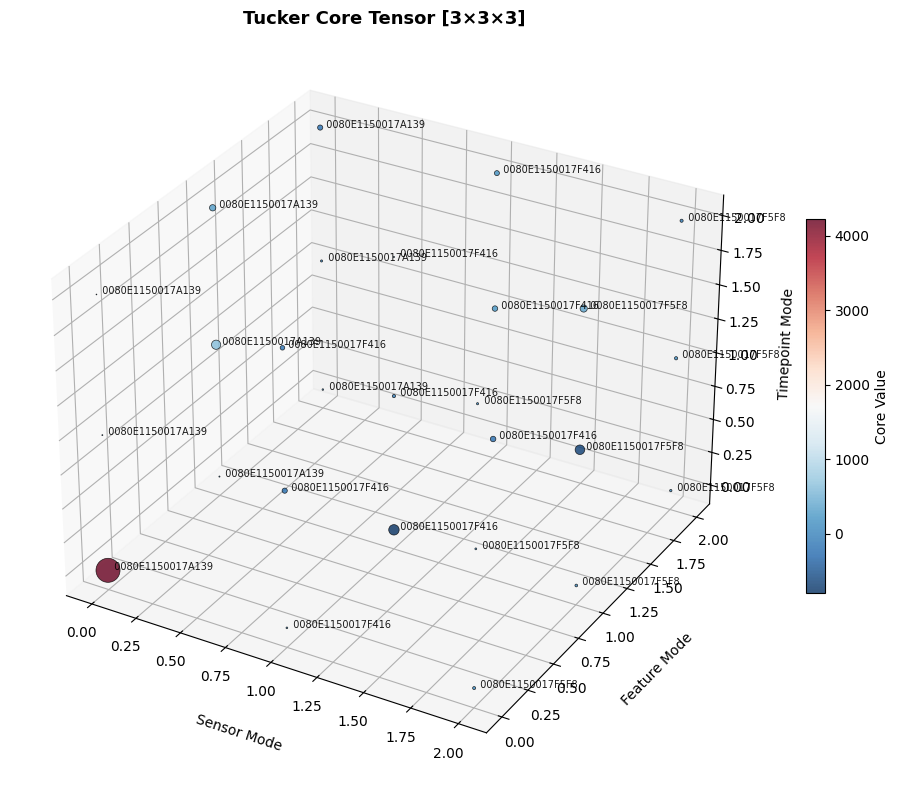

In [62]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.meshgrid(range(ranks[0]), range(ranks[1]), range(ranks[2]), indexing='ij')
values = core.numpy() if hasattr(core, 'numpy') else np.array(core)

x = x.flatten()
y = y.flatten()
z = z.flatten()
v = values.flatten()

sc = ax.scatter(x, y, z,
                c=v,
                s=np.abs(v) / np.abs(v).max() * 300,
                cmap='RdBu_r',
                alpha=0.8,
                edgecolors='k',
                linewidths=0.5)

# Label each point with sensor name
for i, (xi, yi, zi, vi) in enumerate(zip(x, y, z, v)):
    # Map flat index back to sensor component
    sensor_idx = np.unravel_index(i, (ranks[0], ranks[1], ranks[2]))[0]
    ax.text(xi, yi, zi, f'  {sensor_labels[sensor_idx]}', fontsize=7, alpha=0.9)

plt.colorbar(sc, ax=ax, label='Core Value', shrink=0.5)

ax.set_xlabel('Sensor Mode', labelpad=15)
ax.set_ylabel('Feature Mode', labelpad=15)
ax.set_zlabel('Timepoint Mode', labelpad=10)
ax.set_title('Tucker Core Tensor [3×3×3]', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

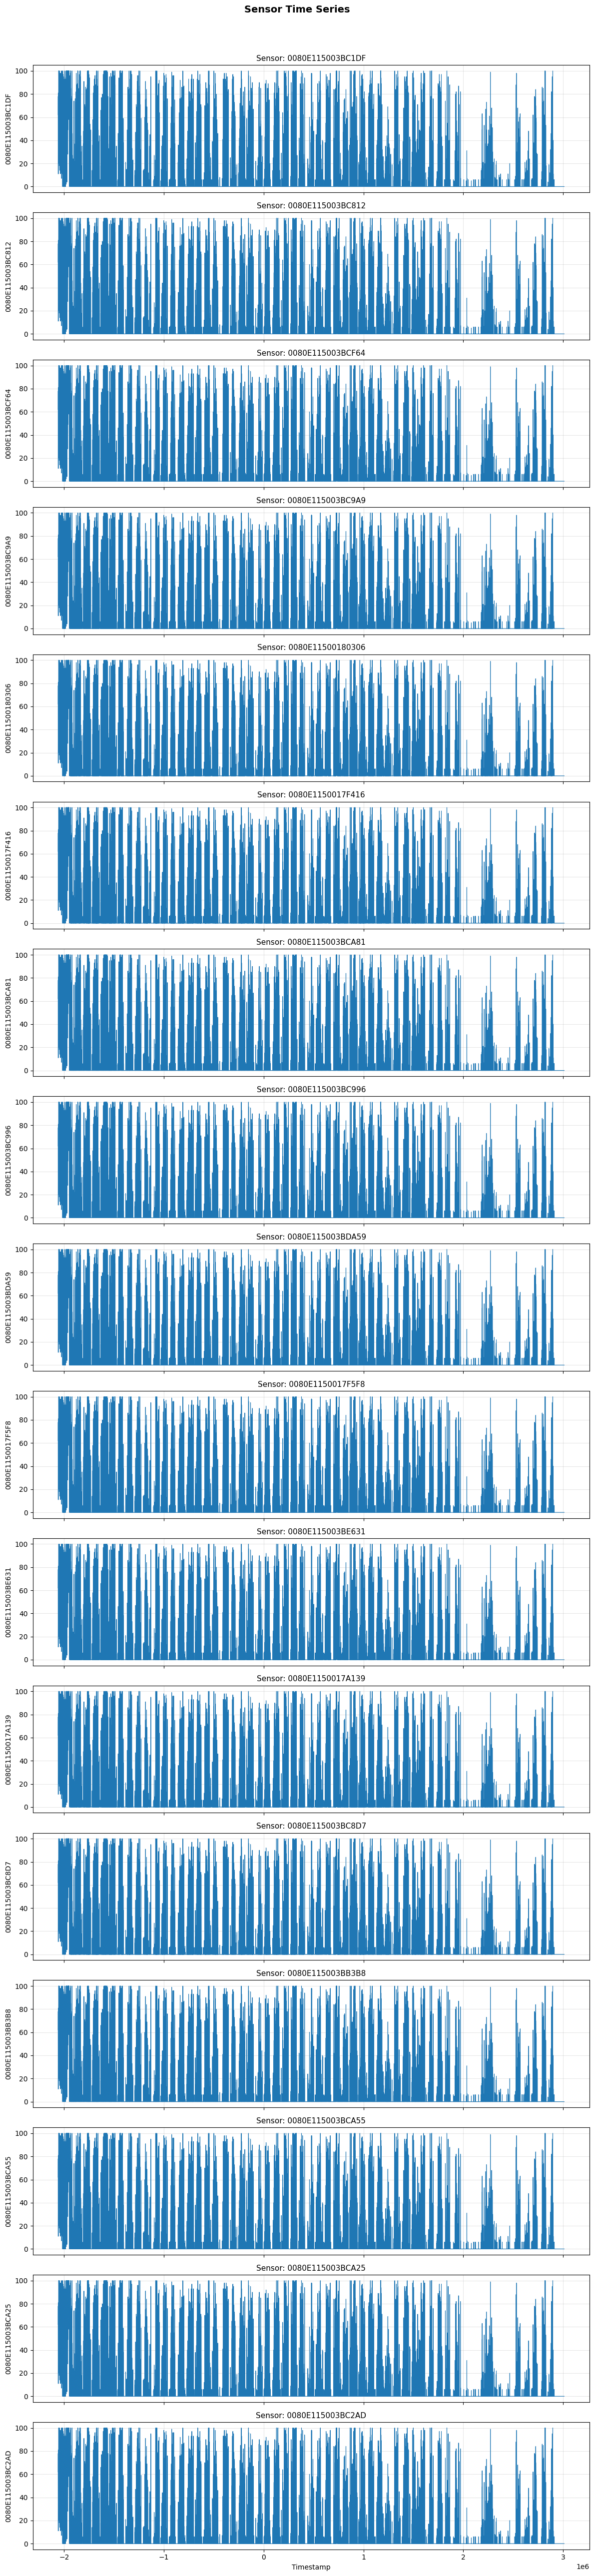

In [49]:
import matplotlib.pyplot as plt

sensors = df['sensor_ID'].unique().tolist()
fig, axes = plt.subplots(len(sensors), 1, figsize=(12, 3 * len(sensors)), sharex=True)

for ax, sensor in zip(axes, sensors):
    df1 = df[(df['sensor_ID'] == sensor) & (df['timestamp'] < 10000)][:250]
    ax.plot(df['timestamp'], df['% occupancy'], linewidth=0.8)
    ax.set_ylabel(sensor, fontsize=10)
    ax.set_title(f'Sensor: {sensor}', fontsize=11)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Timestamp')
fig.suptitle('Sensor Time Series', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
df1 = df[df['sensor_ID'] == '0080E115003BC1DF']
df2 = df[df['sensor_ID'] == '0080E115003BC812']
df3 = df[df['sensor_ID'] == '0080E115003BCF64']
plt.figure(figsize=(12,5))
plt.scatter(df1['longitude'], df1['latitude'],c='red', 
            cmap='viridis',s=2)
plt.scatter(df2['longitude'], df2['latitude'],c='blue', 
            cmap='viridis',s=2)
plt.scatter(df3['longitude'], df3['latitude'],c='green', 
            cmap='viridis',s=2)
plt.colorbar(label='Comfort Index')
plt.title('Spatial Comfort Index')
plt.show()


In [ ]:

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

df['temperature_corrected'] = df['temperature'] - wls.fittedvalues
# df.resample('M', on='date')['temperature'].median().plot(style='-', figsize=(10,4))
df.resample('D', on='date')['temperature'].median().plot(style='.', figsize=(10,4))
df.resample('D', on='date')['temperature'].median().plot(style='-', figsize=(10,4))

df.resample('D', on='date')['temperature_corrected'].median().plot(style='.', figsize=(10,4))
df.resample('D', on='date')['temperature_corrected'].median().plot(style='-', figsize=(10,4))

# temperature, humidity 


In [ ]:

# Center the map on the mean location
center_lat = df['latitude']
center_lon = df['longitude']

plt.scatter(df['latitude'],df['longitude'])

In [ ]:
import plotly.express as px

df2 = df[df['sit'] > 60]
fig = px.scatter_map(
    df2,
    lat="latitude",
    lon="longitude",
    color='sit',
    range_color=[0, 100], 
    zoom=12,
    height=500,
)
fig.update_layout(mapbox_style="open-street-map")

scale_lon_start = df['longitude'].min() + 0.01
scale_lon_end = scale_lon_start + 0.01  # roughly ~1 km depending on latitude
scale_lat = df['latitude'].min() + 0.01

fig.add_shape(
    type="line",
    x0=scale_lon_start,
    y0=scale_lat,
    x1=scale_lon_end,
    y1=scale_lat,
    line=dict(color="black", width=4),
    xref="x",
    yref="y"
)

# Add text annotation for the scale
fig.add_annotation(
    x=(scale_lon_start + scale_lon_end)/2,
    y=scale_lat + 0.002,  # slightly above line
    text="~1 km",
    showarrow=False,
    font=dict(color="black", size=12),
    xref="x",
    yref="y"
)

fig.show()


In [ ]:
# Sika interview 2026 

# write a function the factorial of an input 
# N! = 1*2....N 


def factorial(N):
    if not isinstance(N,int):
        raise Exception("Not an int!")
    if N < 0: 
        raise Exception(f"Invalid value for N {N} ! ")
    if N == 0: 
        return 1 
    
    val = 1 
    for i in range(1,N+1):
        val *= i 

    return val

factorial(4)

In [ ]:
# 

nums = [5,-1,2,-3,3,-5]
# dict[integer]+,- 

def find_largest_positive(arr):
    if not isinstance(arr,list):
        raise Exception("Not a list of values")
    
    if len(arr) <=1 : 
        return -1 
    
    # [-1, 2 ,-3, 3]
    # Optimal: O(n) 

    # O(n*2)
    min_val = None 
    max_val = -1 
    # DICT[value] +, - = dict[value] == 0 maybe this is the max complement
    # 
    val_dict = dict() 
    for val in arr:
        
        # recording the neg in the dict 
        #  
        if val > 0 and val not in val_dict:
            val_dict[val] = True 
        if val < 0 and val in val_dict:
                if max_val < -val: 
                    max_val = -val

        # # try to find a negative value 
        # if val < 0: 
        #     min_val = val  # reminder
        #     # O(n)
        #     for val in arr:  # try to find its complement 
        #         if val > 0 and abs(min_val) == val and max_val < val:
        #             max_val = val  
    return max_val 

find_largest_positive(nums)

In [ ]:
# for a given substring of k = 4 
# find the maximum average in the array 

nums = [1,12,-5,-6,50,3]
k = 4

def find_largest_avg_by_k(nums,k):
    if len(nums) < k:
        return -1 
    
    MAX_avg = 0.0 
    # O(N)
    for i in range(len(nums)):
        avg_i = 0
        # k
        if i+k < len(nums):
            for j in range(k):
                avg_i += nums[i+j] 
            avg_i = float(avg_i / k) 
        if avg_i > MAX_avg: 
            MAX_avg = avg_i 
    # O(n * k)
    return MAX_avg 

find_largest_avg_by_k(nums,k)